<div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="width: 20%; text-align: left; margin-left: 10px;">
        <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRyUtYn-FHY0YTZMTs9yRu8I17EMEVCa_zXow&s" alt="Web Fundación Progreso y Salud" style="width: 100%;"/>
    </div>
    <div style="width: 60%; margin-right: 70px;">
        <p style="text-align: right; font-weight: bold; font-size: 2em; margin-top: 30px;">
            Mesh classificator
        </p>
        <p style="text-align: right; color: #666">
            Proyect: MedicoderMESH
        </p>
        <p style="text-align: right; color: #666">
            Juan Luis González Rodríguez
        </p>
    </div>
</div>

# 0.Libraries

In [1]:
#!pip install matplotlib==3.8.3

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer, BertForSequenceClassification, BertTokenizerFast,BertConfig
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from tqdm import tqdm
import concurrent.futures
from statistics import median, stdev

/home/juanluisgonzalez/FPS_proyects/MediCoderMESH/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Functions

In [3]:
def predict_most_likely_mesh(abstract, model_path, tokenizer, label_encoder):
    """
    Predicts the most likely MeSH term for a given abstract
    
    :param abstract: str, the abstract to predict the MeSH term for
    :param model_path: str, the path to the model to use
    :param tokenizer: BertTokenizerFast, the tokenizer to use
    :param label_encoder: LabelEncoder, the label encoder to use
    
    :return: str, the most likely MeSH term"""
    model = BertForSequenceClassification.from_pretrained(model_path)

    inputs = tokenizer(abstract, return_tensors="pt")
    
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label_idx = logits.argmax().item()
    predicted_label = label_encoder.inverse_transform([predicted_label_idx])
    
    return predicted_label[0]

In [4]:
def top_probable_mesh(text, model_path, tokenizer, label_encoder, n=5):
    """
    Predicts the n most likely MeSH terms for a given abstract

    Params:
    text: str, the abstract to predict the MeSH term for
    model_path: str, the path to the model to use
    tokenizer: BertTokenizerFast, the tokenizer to use
    label_encoder: LabelEncoder, the label encoder to use
    n: int, the number of MeSH terms to return

    Returns:
    df_probabilities: pd.DataFrame, a dataframe with the n most likely MeSH terms and their probabilities
    """
    model = BertForSequenceClassification.from_pretrained(model_path)

    inputs = tokenizer(text, return_tensors="pt")
    
    outputs = model(**inputs)
    
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    dictionary_probabilites = dict(zip(label_encoder.classes_, probabilities.detach().numpy()[0]))
    dictionary_probabilites = {k: f'{v*100:.3f}' for k, v in dictionary_probabilites.items()}

    df_probabilities = pd.DataFrame(dictionary_probabilites.items(), columns=['MESH_MAJOR_TOPIC', 'Probability (%)'])
    df_probabilities = df_probabilities.sort_values(by='Probability (%)', ascending=False)

    df_probabilities = df_probabilities.head(n)
    df_probabilities = df_probabilities.reset_index(drop=True)
    return df_probabilities

# 2. Data preprocessing

In [5]:
df =  pd.read_csv('../data/projects_pubmed.csv', quotechar='"', skipinitialspace=True)

In [6]:
min_pub = 40

filter_df = [group for group in df.groupby('MESH_MAJOR_TOPIC') if len(group[1]) >= min_pub]
filter_df = pd.concat([group[1] for group in filter_df])
filter_df['MESH_MAJOR_TOPIC'].value_counts().values

print(f'There are {len(filter_df)} publications with at least {min_pub} publications in the same MESH_MAJOR_TOPIC')
print(f'There are {len(filter_df["MESH_MAJOR_TOPIC"].unique())} unique MESH_MAJOR_TOPICs in the filtered dataset')

There are 2812 publications with at least 40 publications in the same MESH_MAJOR_TOPIC
There are 61 unique MESH_MAJOR_TOPICs in the filtered dataset


In [7]:
filter_df = filter_df[['ABSTRACT', 'MESH_MAJOR_TOPIC']]

In [8]:
# Encode the Mesh Major Topic
label_encoder = LabelEncoder()

label_encoder.fit(filter_df['MESH_MAJOR_TOPIC'])

filter_df['label'] = label_encoder.transform(filter_df['MESH_MAJOR_TOPIC'])

In [9]:
filter_df.rename(columns={'ABSTRACT':'abstract', 'MESH_MAJOR_TOPIC':'labels decoded'}, inplace=True)
filter_df.reset_index(drop=True, inplace=True)

print(filter_df.info())
display(filter_df.head())
print(f'Shape of the filtered dataset: {filter_df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2812 entries, 0 to 2811
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   abstract        2812 non-null   object
 1   labels decoded  2812 non-null   object
 2   label           2812 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 66.0+ KB
None


,abstract,labels decoded,label
0,El cáncer gástrico representa una de las neopl...,Adenocarcinoma,0
1,El equipo multidisciplinario de cáncer de prós...,Adenocarcinoma,0
2,Antecedentes y objetivos Existen pocos estudio...,Adenocarcinoma,0
3,La principal relevancia clínica del esófago de...,Adenocarcinoma,0
4,Antecedentes y objetivo El tratamiento del ade...,Adenocarcinoma,0


Shape of the filtered dataset: (2812, 3)


In [10]:
tokenizer = BertTokenizerFast.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

/home/juanluisgonzalez/FPS_proyects/MediCoderMESH/.venv/lib64/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
# Select a random abstract
np.random.seed(42)
i = np.random.randint(0, len(filter_df))

abs_original = filter_df.loc[i, 'abstract']
abs_tokenized = tokenizer.tokenize(abs_original)
abs_encoded = tokenizer.encode_plus(abs_original)

# Reconstruc the abstract from the tokens
abs_reconstructed = tokenizer.decode(abs_encoded['input_ids'], verbose=False)

# Print the results
print(f'Original abstract:\n{abs_original}')
print(f'\nTokenized abstract:\n{abs_tokenized}')
print(f'\nInternal representation of the tokenized abstract:\n{abs_encoded}')
print(f'\nReconstructed abstract:\n{abs_reconstructed}')

Original abstract:
Introducción El dolor está considerado como un grave problema en el entorno residencial afectando entre un 49 y un 83% de los residentes. El proceso evolutivo de la enfermedad de Alzheimer puede conllevar dificultades de comunicación y comprensión de las escalas de evaluación de dolor, dificultando su evaluación y tratamiento. El objetivo principal de este estudio fue validar la versión española del PAINAD (PAINAD-Sp) y evaluar su aplicabilidad en un Centro Gerontológico en España. Material y métodos Veinte usuarias diagnosticadas de demencia avanzada fueron observadas por 5 observadores con diferentes perfiles profesionales durante 5min en 3 condiciones: reposo, durante actividad agradable y en situación de dolor. La PAINAD-Sp fue administrada simultáneamente a una escala analógica visual. Resultados Los resultados muestran que el alfa de Cronbach se encontraba entre 0,467 y 0,827 (con una media de 0,692, que subía si el ítem de respiración se eliminaba). La fiabili

In [12]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        
        text = self.texts[idx]
            
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, max_length=self.max_len, padding='max_length')
        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

# Split your data
train_texts, test_texts, train_labels, test_labels = train_test_split(filter_df['abstract'],
                                                                      filter_df['label'],
                                                                      test_size=0.25,
                                                                      stratify=filter_df['label'])
train_texts = train_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create your datasets
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)

In [13]:
# Plot a sample of the dataset
train_dataset[0]

{'input_ids': tensor([    4, 10946, 19754, 30935,  1205,  1162,  1944, 18747,  2128,  1239,
          4088,  1346,  4747,  6118, 12778, 30933,  1058,  1049, 16967,  6118,
         12778, 30933,  1329,  1509,  1282,  1066,  1017,  1038, 12989,  1072,
          1944, 18747,  2128,  4085, 13515,  1035,  1009,  1162,  3219,  1072,
          1642,  1058,  4699,  1049,  1890, 25462,  1008,  1359, 11850,  5602,
          1042,  3335,  1108,  6580,  1008,  1030,  4780, 12792,  1017, 12629,
          1042,  4002,  1009, 23338, 25462, 18155,  1099,  1729,  1008,  2534,
          1503,  1017,  1038,  1062, 17817,  1557,  1008,  1944, 18747,  2128,
          1239,  4088,  1346,  4747,  2131,  1108, 22181,  1383,  9745,  1008,
          1108, 16967,  1086, 10739,  1069, 10074,  1035,  1017,  1036,  1040,
          5044,  1008,  1049,  4718, 26321,  1035, 26445,  1009,  1187,  1040,
          5954,  6652,  6135,  1108,  1807,  1046,  1406,  1008,  1030, 16280,
          1013,  1065,  1115,  1503,  1

# 3. Training

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted',zero_division=1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [15]:
# Get the number of labels
num_labels = len(filter_df['label'].unique())

config = BertConfig.from_pretrained('dccuchile/bert-base-spanish-wwm-cased',num_labels=num_labels,
                                    hidden_dropout_prob=0.2, attention_probs_dropout_prob=0.2)
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased',config=config)
print(model.config)
print(model.config.num_labels)

/home/juanluisgonzalez/FPS_proyects/MediCoderMESH/.venv/lib64/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_name_or_path": "dccuchile/bert-base-spanish-wwm-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.2,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",

In [16]:
training_args = TrainingArguments(
    learning_rate=1e-5,
    warmup_steps=2000,
    output_dir='./results', 
    weight_decay=0.015,
    num_train_epochs=4,                     # Total number of training epochs
    per_device_train_batch_size=2,          # Batch size for training
    per_device_eval_batch_size=8,           # Batch size for evaluation
    logging_dir='./logs',                   # Directory for storing logs
    logging_steps=100,                      # Log every X steps
    evaluation_strategy="steps",            # Evaluate every X steps
    eval_steps=1000,                         # Evaluate every X steps
    report_to="tensorboard",                # Enables logging to TensorBoard
    save_strategy="steps",               # Save every X steps (should match evaluation_strategy for best results)
    save_steps=1000,                      # Save every 1000 steps    
    load_best_model_at_end=True,         # Load the best model at the end
    metric_for_best_model="f1",    # Use f1 for best model selection
    greater_is_better=True,              # Set to False if a lower metric is better (e.g., loss)
    max_grad_norm=0.8,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [17]:
trainer.train()

  2%|▏         | 100/4220 [05:03<3:26:07,  3.00s/it]

{'loss': 4.135, 'grad_norm': 19.228578567504883, 'learning_rate': 5.000000000000001e-07, 'epoch': 0.09}


  5%|▍         | 200/4220 [10:08<3:17:59,  2.96s/it]

{'loss': 4.1357, 'grad_norm': 18.742164611816406, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.19}


  7%|▋         | 300/4220 [15:12<3:23:41,  3.12s/it]

{'loss': 4.1267, 'grad_norm': 18.249082565307617, 'learning_rate': 1.5e-06, 'epoch': 0.28}


  9%|▉         | 400/4220 [20:23<3:23:56,  3.20s/it]

{'loss': 4.1188, 'grad_norm': 18.146512985229492, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.38}


 12%|█▏        | 500/4220 [25:27<3:11:57,  3.10s/it]

{'loss': 4.087, 'grad_norm': 18.66012954711914, 'learning_rate': 2.5e-06, 'epoch': 0.47}


 14%|█▍        | 600/4220 [30:34<3:09:49,  3.15s/it]

{'loss': 4.1315, 'grad_norm': 16.651342391967773, 'learning_rate': 3e-06, 'epoch': 0.57}


 17%|█▋        | 700/4220 [35:32<2:52:12,  2.94s/it]

{'loss': 4.1246, 'grad_norm': 17.914493560791016, 'learning_rate': 3.5e-06, 'epoch': 0.66}


 19%|█▉        | 800/4220 [40:28<2:50:15,  2.99s/it]

{'loss': 4.0974, 'grad_norm': 19.106958389282227, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.76}


 21%|██▏       | 900/4220 [45:28<2:47:06,  3.02s/it]

{'loss': 4.1201, 'grad_norm': 17.32884979248047, 'learning_rate': 4.5e-06, 'epoch': 0.85}


 24%|██▎       | 1000/4220 [50:28<2:43:46,  3.05s/it]

{'loss': 4.0801, 'grad_norm': 17.32711410522461, 'learning_rate': 5e-06, 'epoch': 0.95}


                                                     
 24%|██▎       | 1000/4220 [54:29<2:43:46,  3.05s/it]

{'eval_loss': 4.030977725982666, 'eval_accuracy': 0.03840682788051209, 'eval_f1': 0.018799858336249677, 'eval_precision': 0.8146804746151292, 'eval_recall': 0.03840682788051209, 'eval_runtime': 241.6601, 'eval_samples_per_second': 2.909, 'eval_steps_per_second': 0.364, 'epoch': 0.95}


 26%|██▌       | 1100/4220 [59:32<2:30:28,  2.89s/it] 

{'loss': 4.0454, 'grad_norm': 20.74472427368164, 'learning_rate': 5.500000000000001e-06, 'epoch': 1.04}


 28%|██▊       | 1200/4220 [1:04:28<2:28:44,  2.96s/it]

{'loss': 3.9271, 'grad_norm': 18.930185317993164, 'learning_rate': 6e-06, 'epoch': 1.14}


 31%|███       | 1300/4220 [1:09:26<2:28:34,  3.05s/it]

{'loss': 3.8641, 'grad_norm': 19.748571395874023, 'learning_rate': 6.5000000000000004e-06, 'epoch': 1.23}


 33%|███▎      | 1400/4220 [1:14:19<2:18:34,  2.95s/it]

{'loss': 3.6741, 'grad_norm': 21.462875366210938, 'learning_rate': 7e-06, 'epoch': 1.33}


 36%|███▌      | 1500/4220 [1:19:15<2:12:21,  2.92s/it]

{'loss': 3.556, 'grad_norm': 19.24892234802246, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.42}


 38%|███▊      | 1600/4220 [1:24:09<2:07:59,  2.93s/it]

{'loss': 3.411, 'grad_norm': 20.111318588256836, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.52}


 40%|████      | 1700/4220 [1:29:03<2:05:35,  2.99s/it]

{'loss': 3.2188, 'grad_norm': 25.748489379882812, 'learning_rate': 8.5e-06, 'epoch': 1.61}


 43%|████▎     | 1800/4220 [1:34:00<1:57:07,  2.90s/it]

{'loss': 3.0325, 'grad_norm': 19.8402156829834, 'learning_rate': 9e-06, 'epoch': 1.71}


 45%|████▌     | 1900/4220 [1:39:01<2:00:19,  3.11s/it]

{'loss': 2.914, 'grad_norm': 27.15679359436035, 'learning_rate': 9.5e-06, 'epoch': 1.8}


 47%|████▋     | 2000/4220 [1:43:58<1:55:06,  3.11s/it]

{'loss': 2.7918, 'grad_norm': 18.085622787475586, 'learning_rate': 1e-05, 'epoch': 1.9}


                                                       
 47%|████▋     | 2000/4220 [1:48:00<1:55:06,  3.11s/it]

{'eval_loss': 2.356340169906616, 'eval_accuracy': 0.6557610241820768, 'eval_f1': 0.6118685567924342, 'eval_precision': 0.7027799155346591, 'eval_recall': 0.6557610241820768, 'eval_runtime': 242.1604, 'eval_samples_per_second': 2.903, 'eval_steps_per_second': 0.363, 'epoch': 1.9}


 50%|████▉     | 2100/4220 [1:53:05<1:49:37,  3.10s/it] 

{'loss': 2.521, 'grad_norm': 16.845340728759766, 'learning_rate': 9.54954954954955e-06, 'epoch': 1.99}


 52%|█████▏    | 2200/4220 [1:57:59<1:38:27,  2.92s/it]

{'loss': 2.3436, 'grad_norm': 21.269968032836914, 'learning_rate': 9.0990990990991e-06, 'epoch': 2.09}


 55%|█████▍    | 2300/4220 [2:02:54<1:32:05,  2.88s/it]

{'loss': 2.2749, 'grad_norm': 19.217199325561523, 'learning_rate': 8.64864864864865e-06, 'epoch': 2.18}


 57%|█████▋    | 2400/4220 [2:07:52<1:29:30,  2.95s/it]

{'loss': 2.1069, 'grad_norm': 27.011404037475586, 'learning_rate': 8.198198198198198e-06, 'epoch': 2.27}


 59%|█████▉    | 2500/4220 [2:12:47<1:25:16,  2.97s/it]

{'loss': 2.146, 'grad_norm': 28.48893165588379, 'learning_rate': 7.747747747747749e-06, 'epoch': 2.37}


 62%|██████▏   | 2600/4220 [2:17:40<1:19:15,  2.94s/it]

{'loss': 1.9879, 'grad_norm': 49.67888259887695, 'learning_rate': 7.297297297297298e-06, 'epoch': 2.46}


 64%|██████▍   | 2700/4220 [2:22:35<1:13:29,  2.90s/it]

{'loss': 1.8049, 'grad_norm': 21.84453773498535, 'learning_rate': 6.846846846846848e-06, 'epoch': 2.56}


 66%|██████▋   | 2800/4220 [2:27:30<1:11:45,  3.03s/it]

{'loss': 1.7071, 'grad_norm': 13.955230712890625, 'learning_rate': 6.396396396396397e-06, 'epoch': 2.65}


 69%|██████▊   | 2900/4220 [2:32:26<1:06:26,  3.02s/it]

{'loss': 1.7494, 'grad_norm': 24.19806671142578, 'learning_rate': 5.945945945945947e-06, 'epoch': 2.75}


 71%|███████   | 3000/4220 [2:37:25<59:05,  2.91s/it]  

{'loss': 1.7, 'grad_norm': 17.542936325073242, 'learning_rate': 5.495495495495496e-06, 'epoch': 2.84}


                                                     
 71%|███████   | 3000/4220 [2:41:25<59:05,  2.91s/it]

{'eval_loss': 1.4723117351531982, 'eval_accuracy': 0.6955903271692745, 'eval_f1': 0.6508957078606844, 'eval_precision': 0.7660974681686188, 'eval_recall': 0.6955903271692745, 'eval_runtime': 240.7311, 'eval_samples_per_second': 2.92, 'eval_steps_per_second': 0.366, 'epoch': 2.84}


 73%|███████▎  | 3100/4220 [2:46:27<55:06,  2.95s/it]   

{'loss': 1.6363, 'grad_norm': 10.001526832580566, 'learning_rate': 5.045045045045045e-06, 'epoch': 2.94}


 76%|███████▌  | 3200/4220 [2:51:20<49:41,  2.92s/it]

{'loss': 1.6016, 'grad_norm': 12.75677490234375, 'learning_rate': 4.594594594594596e-06, 'epoch': 3.03}


 78%|███████▊  | 3300/4220 [2:56:22<47:36,  3.11s/it]

{'loss': 1.458, 'grad_norm': 19.586090087890625, 'learning_rate': 4.1441441441441446e-06, 'epoch': 3.13}


 81%|████████  | 3400/4220 [3:01:21<39:53,  2.92s/it]

{'loss': 1.4101, 'grad_norm': 8.026269912719727, 'learning_rate': 3.693693693693694e-06, 'epoch': 3.22}


 83%|████████▎ | 3500/4220 [3:06:19<36:45,  3.06s/it]

{'loss': 1.3958, 'grad_norm': 12.246238708496094, 'learning_rate': 3.2432432432432437e-06, 'epoch': 3.32}


 85%|████████▌ | 3600/4220 [3:11:17<29:20,  2.84s/it]

{'loss': 1.2901, 'grad_norm': 17.006364822387695, 'learning_rate': 2.7927927927927926e-06, 'epoch': 3.41}


 88%|████████▊ | 3700/4220 [3:16:12<26:11,  3.02s/it]

{'loss': 1.4663, 'grad_norm': 13.3759183883667, 'learning_rate': 2.3423423423423424e-06, 'epoch': 3.51}


 90%|█████████ | 3800/4220 [3:21:08<20:29,  2.93s/it]

{'loss': 1.4452, 'grad_norm': 16.934322357177734, 'learning_rate': 1.8918918918918922e-06, 'epoch': 3.6}


 92%|█████████▏| 3900/4220 [3:26:03<15:48,  2.96s/it]

{'loss': 1.3315, 'grad_norm': 27.351619720458984, 'learning_rate': 1.4414414414414416e-06, 'epoch': 3.7}


 95%|█████████▍| 4000/4220 [3:31:01<10:43,  2.92s/it]

{'loss': 1.3488, 'grad_norm': 17.757152557373047, 'learning_rate': 9.909909909909911e-07, 'epoch': 3.79}


                                                     
 95%|█████████▍| 4000/4220 [3:35:04<10:43,  2.92s/it]

{'eval_loss': 1.251009225845337, 'eval_accuracy': 0.7183499288762447, 'eval_f1': 0.6767699619919263, 'eval_precision': 0.7831196055107859, 'eval_recall': 0.7183499288762447, 'eval_runtime': 242.3191, 'eval_samples_per_second': 2.901, 'eval_steps_per_second': 0.363, 'epoch': 3.79}


 97%|█████████▋| 4100/4220 [3:40:04<05:46,  2.89s/it]  

{'loss': 1.3472, 'grad_norm': 19.377307891845703, 'learning_rate': 5.405405405405406e-07, 'epoch': 3.89}


100%|█████████▉| 4200/4220 [3:44:59<00:59,  2.97s/it]

{'loss': 1.2074, 'grad_norm': 10.949501037597656, 'learning_rate': 9.00900900900901e-08, 'epoch': 3.98}


100%|██████████| 4220/4220 [3:45:56<00:00,  3.21s/it]

{'train_runtime': 13556.4817, 'train_samples_per_second': 0.622, 'train_steps_per_second': 0.311, 'train_loss': 2.6813777331492346, 'epoch': 4.0}


TrainOutput(global_step=4220, training_loss=2.6813777331492346, metrics={'train_runtime': 13556.4817, 'train_samples_per_second': 0.622, 'train_steps_per_second': 0.311, 'total_flos': 2220780670267392.0, 'train_loss': 2.6813777331492346, 'epoch': 4.0})

In [18]:
trainer.evaluate()

100%|██████████| 88/88 [03:57<00:00,  2.70s/it]


{'eval_loss': 1.251009225845337,
 'eval_accuracy': 0.7183499288762447,
 'eval_f1': 0.6767699619919263,
 'eval_precision': 0.7831196055107859,
 'eval_recall': 0.7183499288762447,
 'eval_runtime': 240.2508,
 'eval_samples_per_second': 2.926,
 'eval_steps_per_second': 0.366,
 'epoch': 4.0}

In [19]:
model.save_pretrained("model")

# 4. Test

In [30]:
text = "El melanoma es la forma más letal de cáncer de piel, aunque la cirugía a menudo es curativa cuando se combina con la detección y prevención tempranas. En el cáncer recurrente o avanzado, la aparición de la quimioterapia, la terapia dirigida y los inhibidores de puntos de control inmunitarios ha demostrado resultados clínicos prometedores. Estos enfoques pueden detener notablemente la progresión de la enfermedad durante muchos años, aunque están limitados por la adquisición de resistencia. El desarrollo y la aprobación de terapias combinadas han cambiado aún más el paradigma de tratamiento para ciertos melanomas. Esta revisión se centra en el estado actual de la epidemiología del melanoma y en los avances recientes en la detección del melanoma, la clasificación histopatológica, la escisión en etapas (es decir, escisión local amplia, biopsia de ganglio centinela y cirugía micrográfica de Mohs), y el tratamiento sistémico."
real_label = "Melanoma"
label_predicted = predict_most_likely_mesh(text, "model", tokenizer, label_encoder)

print(f'The abstract is:\n{text}')
print(f'\nThe real label is:\t{real_label}')
print(f'The predicted label is:', end='\t')

if real_label == label_predicted:
    print(f'\033[92m{label_predicted}\033[0m')
else:
    print(f'\033[91m{label_predicted}\033[0m')

The abstract is:
El melanoma es la forma más letal de cáncer de piel, aunque la cirugía a menudo es curativa cuando se combina con la detección y prevención tempranas. En el cáncer recurrente o avanzado, la aparición de la quimioterapia, la terapia dirigida y los inhibidores de puntos de control inmunitarios ha demostrado resultados clínicos prometedores. Estos enfoques pueden detener notablemente la progresión de la enfermedad durante muchos años, aunque están limitados por la adquisición de resistencia. El desarrollo y la aprobación de terapias combinadas han cambiado aún más el paradigma de tratamiento para ciertos melanomas. Esta revisión se centra en el estado actual de la epidemiología del melanoma y en los avances recientes en la detección del melanoma, la clasificación histopatológica, la escisión en etapas (es decir, escisión local amplia, biopsia de ganglio centinela y cirugía micrográfica de Mohs), y el tratamiento sistémico.

The real label is:	Melanoma
The predicted label 

In [31]:
print('\nTop 5 probable MeSH terms:')
top_probable_mesh(text, "model", tokenizer, label_encoder, n=5)


Top 5 probable MeSH terms:


,MESH_MAJOR_TOPIC,Probability (%)
0,Skin Neoplasms,7.843
1,Melanoma,54.635
2,Lymphatic Metastasis,1.747
3,"Carcinoma, Basal Cell",1.624
4,"Lupus Erythematosus, Systemic",1.549


In [22]:
tuple_evaluation = ()
model = BertForSequenceClassification.from_pretrained("model")

def process_row(i):
    row = test_dataset[i]
    real_label = row['labels'].item()
    inputs = {k: v.unsqueeze(0) for k, v in row.items() if k != 'labels'}
    outputs = model(**inputs)
    predicted_label_idx = outputs.logits.argmax().item()
    return (real_label, predicted_label_idx)

with concurrent.futures.ThreadPoolExecutor() as executor:
    tuple_evaluation = list(executor.map(process_row, range(len(test_dataset))))

In [23]:
num_labels = len(filter_df['label'].unique())

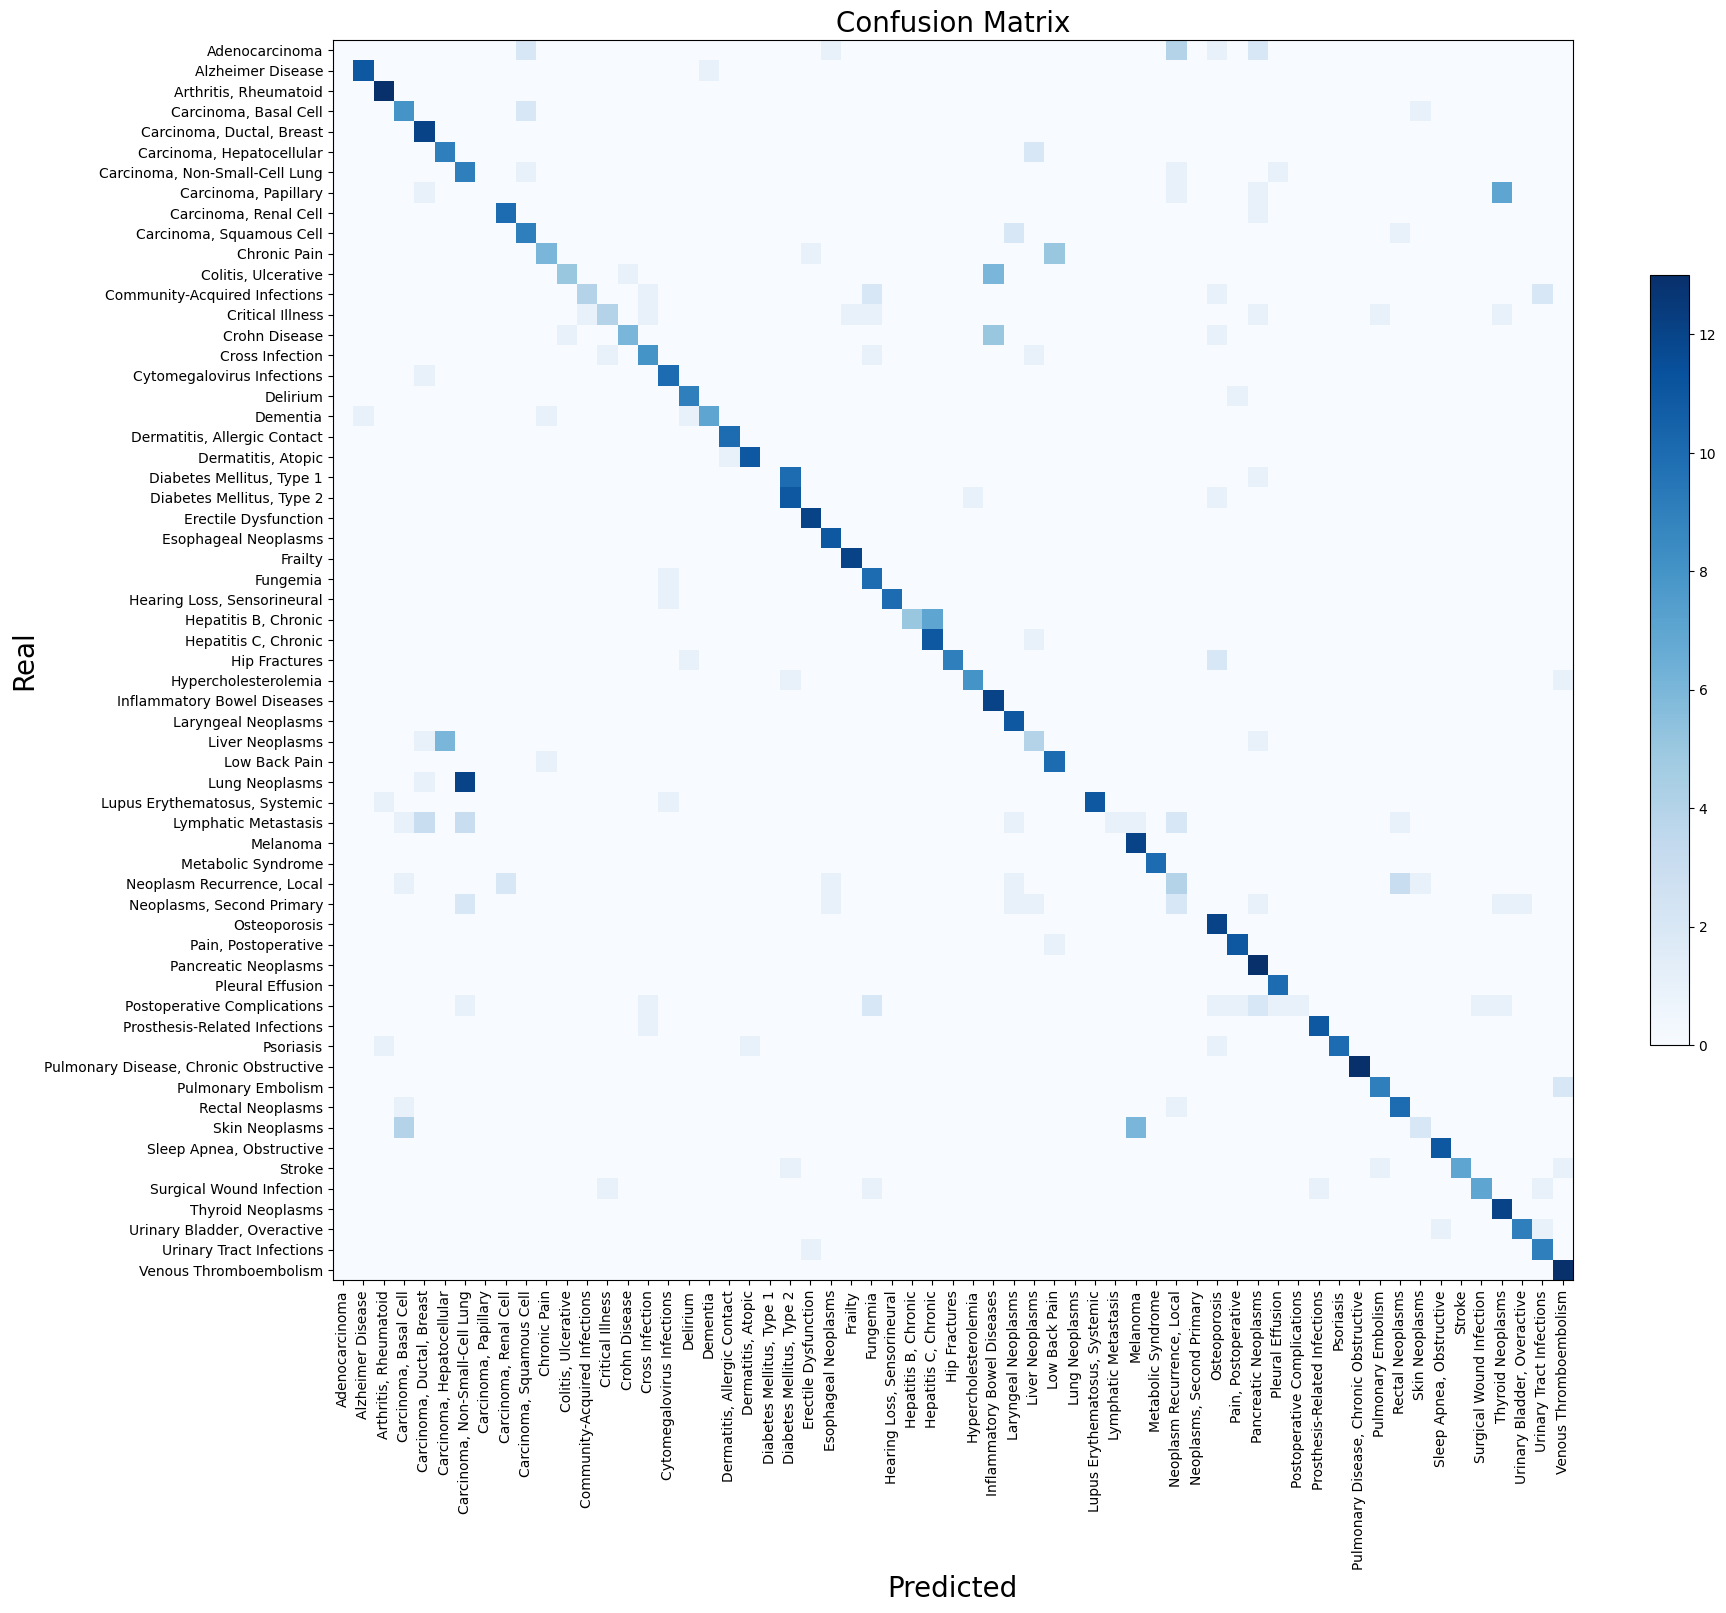

In [24]:
tuple_evaluation = np.array(tuple_evaluation)
real_labels = tuple_evaluation[:, 0]
predicted_labels = tuple_evaluation[:, 1]

confusion_matrix = confusion_matrix(real_labels, predicted_labels)

plt.figure(figsize=(20, 20))
plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Real', fontsize=20)
plt.xticks(range(num_labels), label_encoder.classes_, rotation=90)
plt.yticks(range(num_labels), label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=20)
plt.colorbar(shrink=0.5)
plt.show()

In [25]:
real_labels = [real_label_idx for real_label_idx, _ in tuple_evaluation]
predicted_labels = [predicted_label_idx for _, predicted_label_idx in tuple_evaluation]

accuracy = accuracy_score(real_labels, predicted_labels)
precision = precision_score(real_labels, predicted_labels, average='weighted')
recall = recall_score(real_labels, predicted_labels, average='weighted')
f1 = f1_score(real_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1: {f1:.2f}')


Accuracy: 0.72
Precision: 0.71
Recall: 0.72
F1: 0.68


/home/juanluisgonzalez/FPS_proyects/MediCoderMESH/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# Number of iterations
n = 100

# Initialize lists to store metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for _ in range(n):
    # Create a random model
    random_model = list(np.random.randint(0, num_labels, len(test_dataset)))

    real_labels = [real_label_idx for real_label_idx, _ in tuple_evaluation]
    predicted_labels = random_model

    # Calculate metrics
    rand_accuracy = accuracy_score(real_labels, predicted_labels)
    rand_precision = precision_score(real_labels, predicted_labels, average='weighted')
    rand_recall = recall_score(real_labels, predicted_labels, average='weighted')
    rand_f1 = f1_score(real_labels, predicted_labels, average='weighted')

    # Append metrics to lists
    accuracy_list.append(rand_accuracy)
    precision_list.append(rand_precision)
    recall_list.append(rand_recall)
    f1_list.append(rand_f1)

# Calculate and print median and standard deviation of each metric
print(f"Random model metrics for {n} iterations:")
print(f'Accuracy: Median={median(accuracy_list):.2f}, Std={stdev(accuracy_list):.2f}')
print(f'Precision: Median={median(precision_list):.2f}, Std={stdev(precision_list):.2f}')
print(f'Recall: Median={median(recall_list):.2f}, Std={stdev(recall_list):.2f}')
print(f'F1: Median={median(f1_list):.2f}, Std={stdev(f1_list):.2f}')

Random model metrics for 100 iterations:
Accuracy: Median=0.02, Std=0.00
Precision: Median=0.02, Std=0.01
Recall: Median=0.02, Std=0.00
F1: Median=0.02, Std=0.00
